In [41]:
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
plot_style()
%matplotlib inline
plt.style.use('dark_background') #for posters

In [2]:
def compute_colors(s, xkey, ykey):
    #print (xkey, ykey)
    xmag= filterMag(s ,xkey, ab=False)
    ymag= filterMag(s, ykey, ab=False)
    return xmag[0]-ymag[0], (xmag[1]**2+ymag[1]**2)**0.5

In [3]:
COLOR_TERMS=['LSST_GandLSST_R',
            'LSST_RandLSST_Z',
            'LSST_IandLSST_Z',
             'LSST_RandLSST_I']

In [8]:
    

def spt_to_teff(spt, sd=True):
    if sd:
        if spt >25:  
            return  spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
        else:
            return spe.typeToTeff(spt, reverse=False, ref='gonzales18')[0].value
    if not sd:
        return spe.typeToTeff(teff,  reverse=False, ref='pecaut')[0].value
    
def teff_to_spt(teff, sd=True):
    if sd:
        if teff <1600: #use dwarfs for higher teff 
            return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
        else:
            return spe.typeToTeff(teff, reverse=True, ref='gonzales18')[0]
    if not sd:
        return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]

In [9]:
#/subdwarfs_gerasimov.npy',

In [10]:
def get_sd_models(model='gerasimov'):
    #ADD models
    sdmodels=np.load('/Volumes/LaCie/popsimsdata/subdwarfs_models_{}.npy'.format(model), allow_pickle=True)[0]
    additional_keys=['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H', '2MASS K']
    all_keys= np.concatenate([additional_keys, np.unique(np.concatenate([x.split('and') for x in COLOR_TERMS]))])
    model_vals=dict(zip(all_keys, []))


    #compute values from filtermags
    #ADD ADDITIONAL FITS FOR SLOAN AND 2 MASS TO TAKE ADAVTANGE OF METAL-POOR MODELS
    
    for k in all_keys:
        mags= np.vstack([filterMag(x, k) for x in sdmodels['spectra']])
        model_vals[k]=mags[:,0] 
        model_vals[k+'_er']= 0.#(mags[:,1]**2+ np.nanmedian(df_sd_dwarfs[k+'_er'])**2)**0.5#add a fudicial 0.1 scatter

    sdmodel_df=pd.DataFrame(model_vals)
    sdmodel_df['spt']=[ teff_to_spt(x, sd=True) for x in sdmodels['teff']]
    sdmodel_df['spt']= np.array(sdmodel_df['spt'])
    sdmodel_df['teff']= sdmodels['teff']
    sdmodel_df['z']= sdmodels['z']
    return sdmodel_df

In [11]:
df_mov=  get_sd_models()
df_line= get_sd_models(model='line2021')

In [54]:
df_line=df_line[df_line.z <=-0.5]

In [18]:
#LOAD DP0 data
dp0_data=pd.read_csv('/Volumes/lacie/popsimsdata/cone_search.csv')

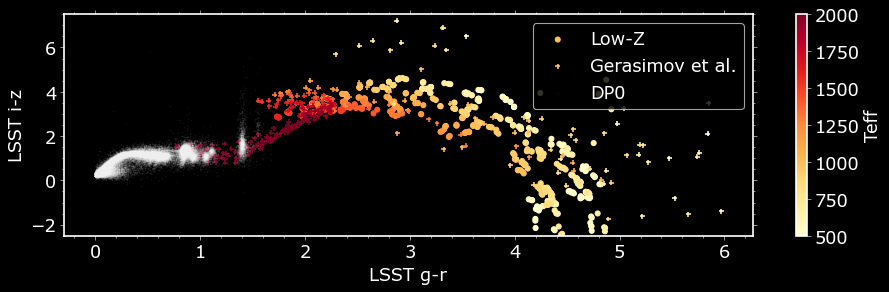

In [65]:
fig, ax=plt.subplots(figsize=(12, 4))
c=ax.scatter(df_line.LSST_I-df_line.LSST_Z, df_line.LSST_G-df_line.LSST_R, c=df_line.teff.values, vmin=500, vmax=2000, marker='o', cmap='YlOrRd', label='Low-Z', alpha=1, s=20)
ax.scatter(df_mov.LSST_I-df_mov.LSST_Z, df_mov.LSST_G-df_mov.LSST_R, c=df_mov.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', label='Gerasimov et al.', alpha=1, s=20)
ax.scatter(dp0_data.mag_i-dp0_data.mag_z, dp0_data.mag_g-dp0_data.mag_r, color='w', label='DP0', s=.1, alpha=0.1)

cbar=plt.colorbar(c, label=r'Teff')
ax.minorticks_on()
ax.legend()
ax.set(ylim=[-2.5, 7.5], xlabel='LSST g-r', ylabel='LSST i-z')
plt.tight_layout()
plt.savefig('../figures/lsst_colors.jpeg')